In [ ]:
# importing required libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

# Exercise 1: Wide Deep Cross Networks — Covertype Dataset

This dataset, part of the UCI Machine Learning Repository, contains tree observations from four areas of the Roosevelt National Forest in Colorado. All observations are cartographic variables (no remote sensing) from 30 meter x 30 meter sections of forest.

It includes information on tree type, shadow coverage, distance to nearby landmarks (roads etc), soil type, and local topography.


In [ ]:
# loading the dataset
data_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz")
raw_data = pd.read_csv(data_url, header=None)
print(f"Shape of the dataset: {raw_data.shape}")

Shape of the dataset: (581012, 55)


In [ ]:
# preview of the dataset
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
# converting to a more readable form with each categorical feature represented as a single integer value

soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]                  # 40 types of soil
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]             # 4 types of wilderness areas

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# converting the target label indices into the range 0-6 (7 labels in total)
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Shape of the new dataset with combined features: {data.shape}")

Shape of the new dataset with combined features: (581012, 13)


In [ ]:
# new dataset
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


In [ ]:
# splitting the data into train and test sets (85%, 15%)
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494026
Test split size: 86986


In [ ]:
# storing train and test data in separate files
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [ ]:
# defining the metadata
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [ ]:
# function to read and parse input data and convert to a tf dataset
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [ ]:
# function to create model inputs as a dictionary with keys as feature names
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
# function to encode inputs (using categoryencoding or embedding)

#from tensorflow.keras.layers import StringLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = tf.keras.layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [ ]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50
hidden_units = [32, 32]

# function to train and evaluate a model

def run(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    history = model.fit(train_dataset, epochs=num_epochs)

    loss, accuracy = model.evaluate(test_dataset, verbose=1)

    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy * 100}%")

In [ ]:
# creating a  multi-layer  feed-forward  network  where  the  categorical  features  are  one-hot encoded
def create_ff_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

ff_model = create_ff_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
run(ff_model)

Epoch 1/50
1865/1865 [==============================] - 16s 8ms/step - loss: 0.7677 - sparse_categorical_accuracy: 0.6803
Epoch 2/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.7137
Epoch 3/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7257
Epoch 4/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.6151 - sparse_categorical_accuracy: 0.7350
Epoch 5/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.7415
Epoch 6/50
1865/1865 [==============================] - 10s 6ms/step - loss: 0.5947 - sparse_categorical_accuracy: 0.7447
Epoch 7/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5890 - sparse_categorical_accuracy: 0.7466
Epoch 8/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5847 - sparse_categorical_accuracy: 0.7487
Epoch 9/50
1865/1865 [=====

In [ ]:
# creating a wide & deep model
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

wide_and_deep_model = create_wide_and_deep_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
run(wide_and_deep_model)

Epoch 1/50
1865/1865 [==============================] - 18s 9ms/step - loss: 0.7091 - sparse_categorical_accuracy: 0.7001
Epoch 2/50
1865/1865 [==============================] - 13s 7ms/step - loss: 0.6046 - sparse_categorical_accuracy: 0.7369
Epoch 3/50
1865/1865 [==============================] - 14s 7ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.7440
Epoch 4/50
1865/1865 [==============================] - 18s 10ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.7497
Epoch 5/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5657 - sparse_categorical_accuracy: 0.7544
Epoch 6/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.7583
Epoch 7/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5524 - sparse_categorical_accuracy: 0.7609
Epoch 8/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.7636
Epoch 9/50
1865/1865 [=

In [ ]:
# creating a deep & cross model
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
run(deep_and_cross_model)

Epoch 1/50
1865/1865 [==============================] - 19s 9ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.7084
Epoch 2/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7450
Epoch 3/50
1865/1865 [==============================] - 16s 8ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.7513
Epoch 4/50
1865/1865 [==============================] - 12s 7ms/step - loss: 0.5620 - sparse_categorical_accuracy: 0.7563
Epoch 5/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5540 - sparse_categorical_accuracy: 0.7597
Epoch 6/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5471 - sparse_categorical_accuracy: 0.7627
Epoch 7/50
1865/1865 [==============================] - 14s 8ms/step - loss: 0.5426 - sparse_categorical_accuracy: 0.7652
Epoch 8/50
1865/1865 [==============================] - 13s 7ms/step - loss: 0.5379 - sparse_categorical_accuracy: 0.7672
Epoch 9/50
1865/1865 [==

The simple multi-layer feed-forward network shows an accuracy of 76.85% and loss of 0.52.
<br><br>
The wide & deep model shows an accuracy of 80.01% and loss of 0.46.
<br><br>
The deep & cross model shows an accuracy of 81.03% and loss of 0.44.
<br><br>
In conclusion, the deep & cross model achieves better performance and takes feature interactions into account as well.
<br><br><hr>

# Exercise 2: RNN vs LSTM — Google Stock Price Dataset

In [ ]:
# importing the required libraries
from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# loading the data
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_train = pd.read_csv('Google_Stock_Price_Train.csv')
df = pd.concat([df_test,df_train])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume
0,01-03-2017,778.81,789.63,775.80,786.14,"16,57,300"
1,01-04-2017,788.36,791.34,783.16,786.9,"10,73,000"
2,01-05-2017,786.08,794.48,785.02,794.02,"13,35,200"
3,01-06-2017,795.26,807.90,792.20,806.15,"16,40,200"
4,01-09-2017,806.40,809.97,802.83,806.65,"12,72,400"


In [ ]:
df = df.loc[:, ["Open"]].values
train = df[:len(df) - 50] 
test = df[len(train):] 
# reshape
train = train.reshape(train.shape[0], 1)

In [ ]:
# scaling the train data
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train)

In [ ]:
# building scaled train set of 50 timesteps
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [ ]:
# initialising the RNN
rnn = Sequential()

# first layer
rnn.add(SimpleRNN(units = 50, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn.add(Dropout(0.2)) 

# second layer
rnn.add(SimpleRNN(units = 50, activation='relu', return_sequences = True))
rnn.add(Dropout(0.2))

# third layer 
rnn.add(SimpleRNN(units = 50, activation='relu', return_sequences = True))
rnn.add(Dropout(0.2))

# fourth layer
rnn.add(SimpleRNN(units = 50))
rnn.add(Dropout(0.2))

# output layer
rnn.add(Dense(units = 1))

# compiling the RNN
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the training set
history = rnn.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 8s 155ms/step - loss: 0.0873
Epoch 2/100
37/37 [==============================] - 6s 160ms/step - loss: 0.0186
Epoch 3/100
37/37 [==============================] - 6s 154ms/step - loss: 0.0109
Epoch 4/100
37/37 [==============================] - 8s 212ms/step - loss: 0.0090
Epoch 5/100
37/37 [==============================] - 6s 158ms/step - loss: 0.0080
Epoch 6/100
37/37 [==============================] - 6s 156ms/step - loss: 0.0070
Epoch 7/100
37/37 [==============================] - 6s 176ms/step - loss: 0.0063
Epoch 8/100
37/37 [==============================] - 7s 181ms/step - loss: 0.0055
Epoch 9/100
37/37 [==============================] - 10s 269ms/step - loss: 0.0051
Epoch 10/100
37/37 [==============================] - 8s 209ms/step - loss: 0.0046
Epoch 11/100
37/37 [==============================] - 7s 188ms/step - loss: 0.0051
Epoch 12/100
37/37 [==============================] - 6s 161ms/step - loss: 0.0048
Epoch 13/100

In [ ]:
inputs = df[len(df) - len(test) - timesteps:]
inputs = scaler.transform(inputs)

In [ ]:
# building test set of 50 timesteps
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# predicting using the values in the test set
predicted_data = rnn.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

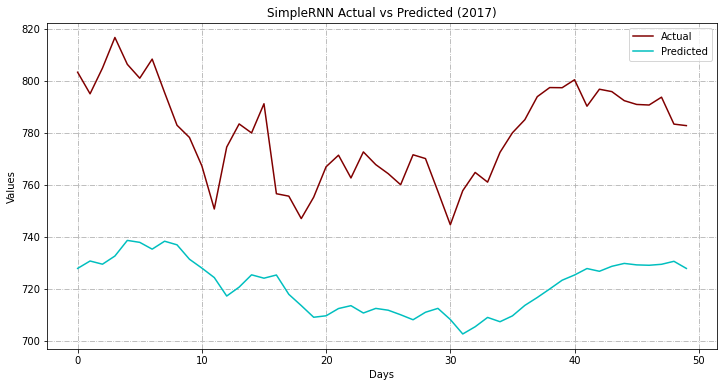

In [ ]:
# plotting actual vs predicted values for 2017 (RNN)
plt.figure(figsize=(12,6))
plt.title("SimpleRNN Actual vs Predicted (2017)")
plt.plot(test, color="maroon", label="Actual")
plt.plot(predicted_data, color="c", label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(linestyle='dashdot')
plt.show()

In [ ]:
# building and fitting an LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(None, 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer='Adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
1178/1178 [==============================] - 10s 5ms/step - loss: 0.0110
Epoch 2/50
1178/1178 [==============================] - 5s 4ms/step - loss: 0.0014
Epoch 3/50
1178/1178 [==============================] - 5s 4ms/step - loss: 9.6289e-04
Epoch 4/50
1178/1178 [==============================] - 5s 4ms/step - loss: 7.9301e-04
Epoch 5/50
1178/1178 [==============================] - 5s 4ms/step - loss: 6.8410e-04
Epoch 6/50
1178/1178 [==============================] - 5s 4ms/step - loss: 6.3887e-04
Epoch 7/50
1178/1178 [==============================] - 5s 4ms/step - loss: 5.5382e-04
Epoch 8/50
1178/1178 [==============================] - 8s 6ms/step - loss: 4.8150e-04
Epoch 9/50
1178/1178 [==============================] - 6s 5ms/step - loss: 4.2060e-04
Epoch 10/50
1178/1178 [==============================] - 6s 5ms/step - loss: 4.1530e-04
Epoch 11/50
1178/1178 [==============================] - 5s 4ms/step - loss: 3.9071e-04
Epoch 12/50
1178/1178 [=========================

In [ ]:
# predicting using the values in the test set
predicted_data2 = model.predict(X_test)
predicted_data2 = scaler.inverse_transform(predicted_data2)

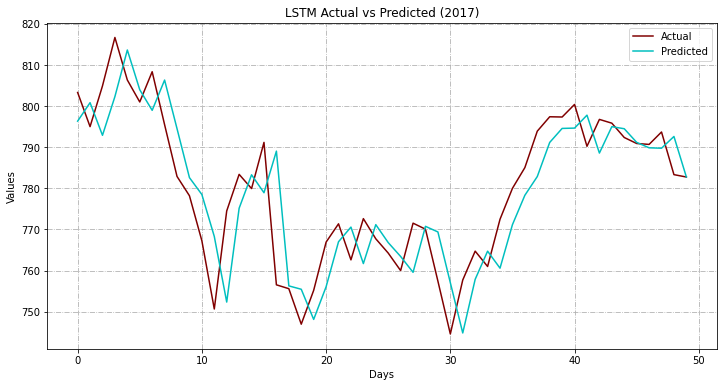

In [ ]:
# plotting
plt.figure(figsize=(12,6))
plt.title("LSTM Actual vs Predicted (2017)")
plt.plot(test, color="maroon", label="Actual")
plt.plot(predicted_data2, color="c", label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(linestyle='dashdot')
plt.show()

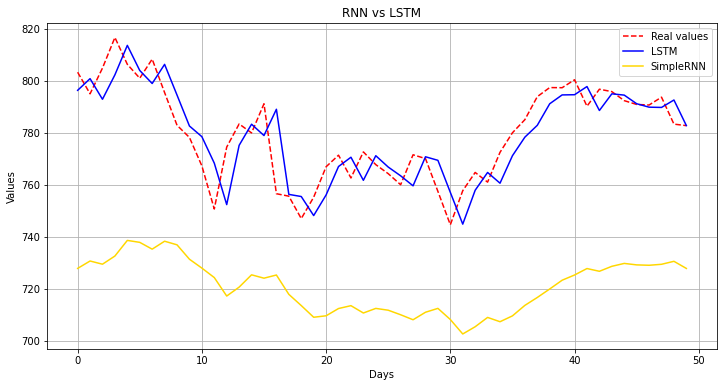

In [ ]:
# comparing the two
plt.figure(figsize=(12,6))
plt.title("RNN vs LSTM")
plt.plot(test,color="red", linestyle='dashed', label="Real values")
plt.plot(predicted_data2, color="blue", label="LSTM")
plt.plot(predicted_data, color="gold", label="SimpleRNN")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()